In [21]:
import pandas as pd
import numpy as np
import random
from SimulatedSubjectData import *
import matplotlib.pyplot as plt
import pickle

In [22]:
def save_data(data, filename):
    """
    Save a dictionary where keys are ints or tuples, and values are lists of time series arrays.

    Parameters
    ----------
    data_dict : dict
        Keys: int or tuple (e.g., 1, (2,4))
        Values: list of lists or numpy arrays (time series data)
    filename : str
        Path to save file (should end in .pkl)
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Dictionary saved to {filename}")

def load_data(filename):
    """
    Load a dictionary saved with save_timeseries_dict().
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [23]:
with open("words.pkl", "rb") as f:
    wordpool = pickle.load(f)

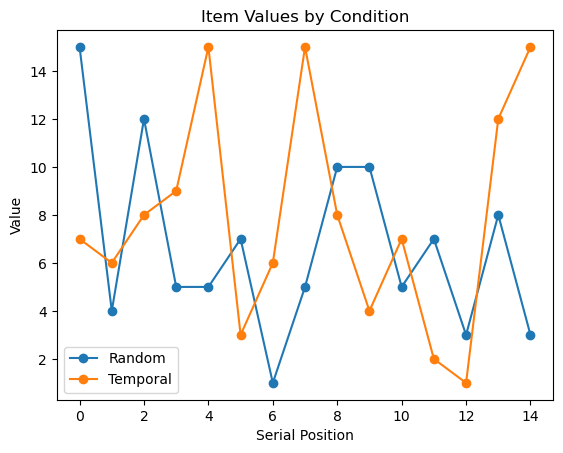

In [24]:
item_list_rand = ItemList(15, condition="Random")
item_list_temp = ItemList(15, condition="Temporal")

# Plot the values
plt.plot(item_list_rand.vals, label="Random", marker='o')
plt.plot(item_list_temp.vals, label="Temporal", marker='o')

plt.xlabel("Serial Position")
plt.ylabel("Value")
plt.title("Item Values by Condition")
plt.legend()
plt.show()

In [28]:
# Autocorrelation for a single list
def autocorr(x):
    x = np.array(x)
    n = len(x)
    ac = []
    for lag in range(n):
        if lag == 0:
            ac.append(np.nan)  # optional
        elif n-lag < 2 or np.std(x[:n-lag]) == 0 or np.std(x[lag:]) == 0:
            ac.append(0)  # cannot compute correlation
        else:
            ac.append(np.corrcoef(x[:n-lag], x[lag:])[0,1])
    return np.array(ac)

# Compute mean autocorrelation across all lists
def mean_autocorr(list_of_vals):
    ac_matrix = np.array([autocorr(vals) for vals in list_of_vals])
    return np.mean(ac_matrix, axis=0)  # signed mean

# # Temporal vs Random autocorr
# temporal_ac = mean_autocorr(temp_vals)
# random_ac = mean_autocorr(rand_vals)

# print(f"Mean auto correlation (Temporal): {np.nanmean(temporal_ac):.3f}")
# print(f"Mean auto correlation (Random): {np.nanmean(random_ac):.3f}")

# temporal_ac[0] = np.nan
# random_ac[0] = np.nan
# # Plot autocorrelation by lag
# plt.plot(random_ac, label="Random")
# plt.plot(temporal_ac, label="Temporal")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")
# plt.xlim([0,14])
# # plt.ylim([0,1])
# plt.title("Mean Signed Autocorrelation by Lag")
# plt.legend()
# plt.show()

# Consecutive correlation for a single list
# def consecutive_corr(vals):
#     return np.corrcoef(vals[:-1], vals[1:])[0,1]

# # # Compute mean consecutive correlation across lists
# # mean_consec_corr_temp = np.mean([consecutive_corr(vals) for vals in temp_vals])
# # mean_consec_corr_rand = np.mean([consecutive_corr(vals) for vals in rand_vals])

# print(f"Mean consecutive correlation (Temporal): {mean_consec_corr_temp:.3f}")
# print(f"Mean consecutive correlation (Random): {mean_consec_corr_rand:.3f}")


In [ ]:
# Simulation parameters
n_lists = 5000
list_length = 15
lag_max = 14

# Independent variable: scaling factor for GP parameters
scales = np.arange(1, 7)  # 1x to 6x
avg_ac_by_scale = []

# Default GP parameter ranges
base_val_range = (0, 15)
base_mean_range = (4, 10)
base_var_range = (2, 6)

for scale in tqdm(scales, desc="Processing scales"):
    temp_vals = []
    # Scale the ranges proportionally
    scaled_gp_params = {
        "val_range": (base_val_range[0]*scale, base_val_range[1]*scale),
        "mean_range": (base_mean_range[0]*scale, base_mean_range[1]*scale),
        "var_range": (base_var_range[0]*scale, base_var_range[1]*scale),
        "decay_factor": 1.0,
        "effect_strength": 1.0
    }
    for _ in range(n_lists):
        lst = ItemList(length=list_length, condition="Temporal", gp_params=scaled_gp_params)
        temp_vals.append(lst.vals)
    avg_ac = mean_autocorr(temp_vals)
    avg_ac_by_scale.append(avg_ac)

avg_ac_by_scale = np.array(avg_ac_by_scale)

# Plot
plt.figure(figsize=(10,6))
for i, scale in enumerate(scales):
    plt.plot(range(lag_max+1), avg_ac_by_scale[i,:lag_max+1], label=f"Scale {scale}x")
plt.xlabel("Lag")
plt.ylabel("Mean Autocorrelation")
plt.title("Mean Autocorrelation by Lag for Different GP Parameter Scales")
plt.legend()
plt.show()



Processing val_scales: 100%|██████████| 6/6 [01:08<00:00, 11.38s/it]


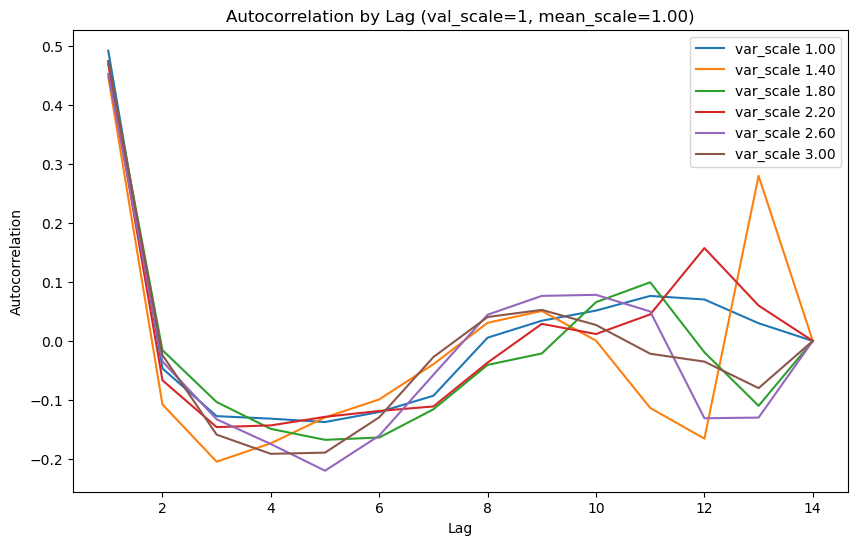

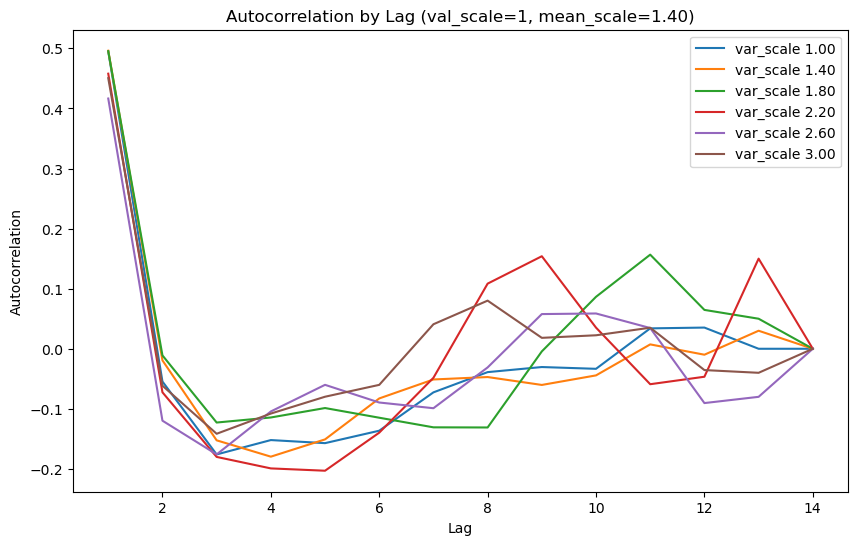

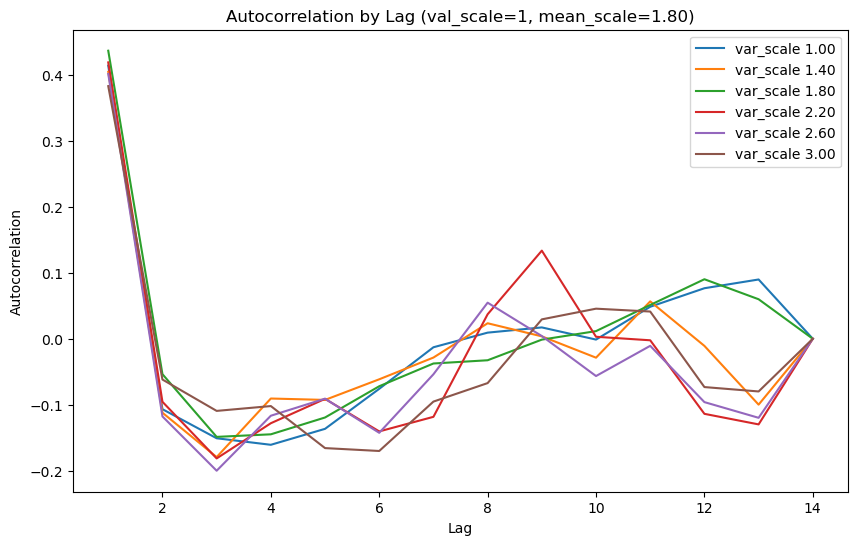

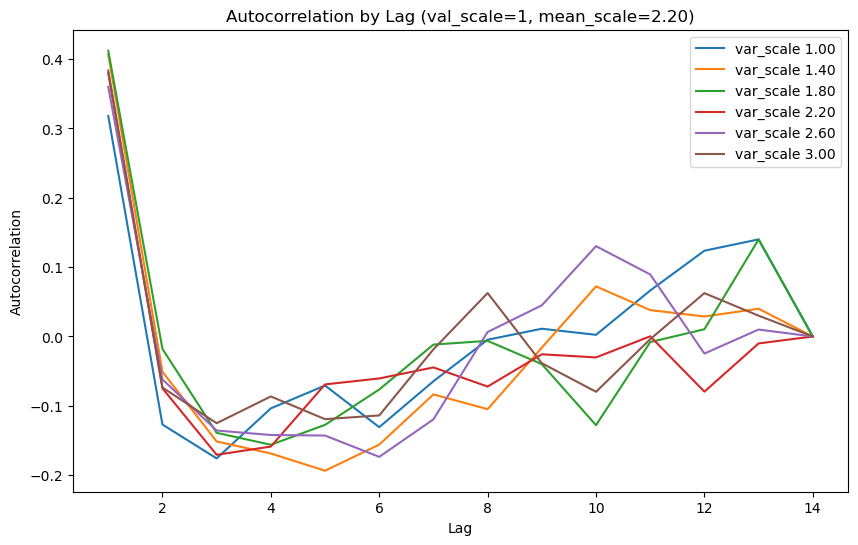

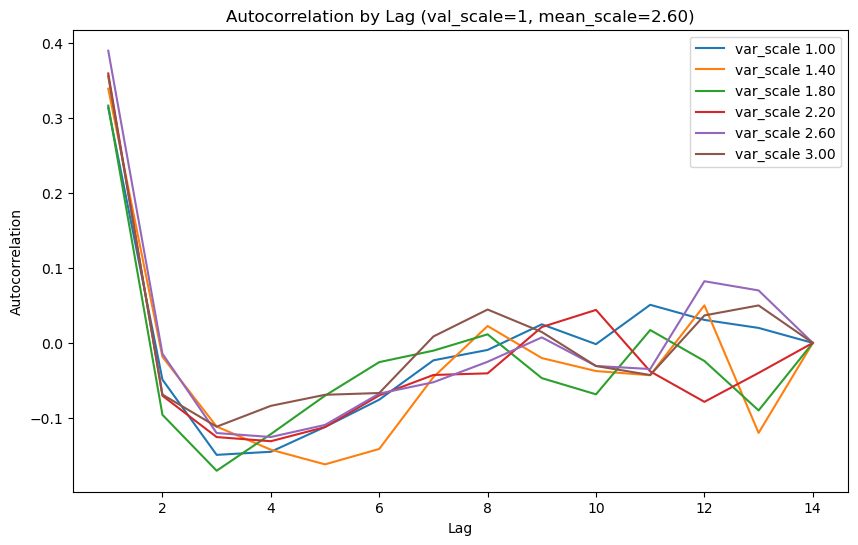

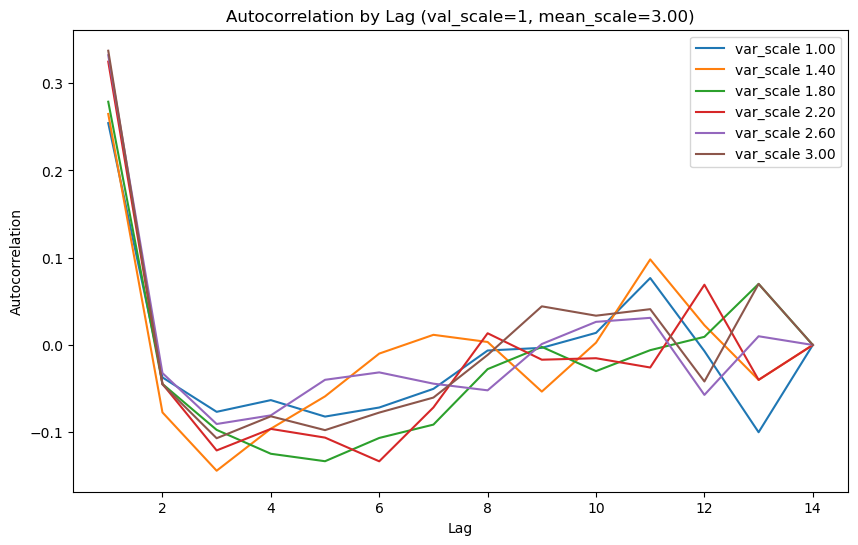

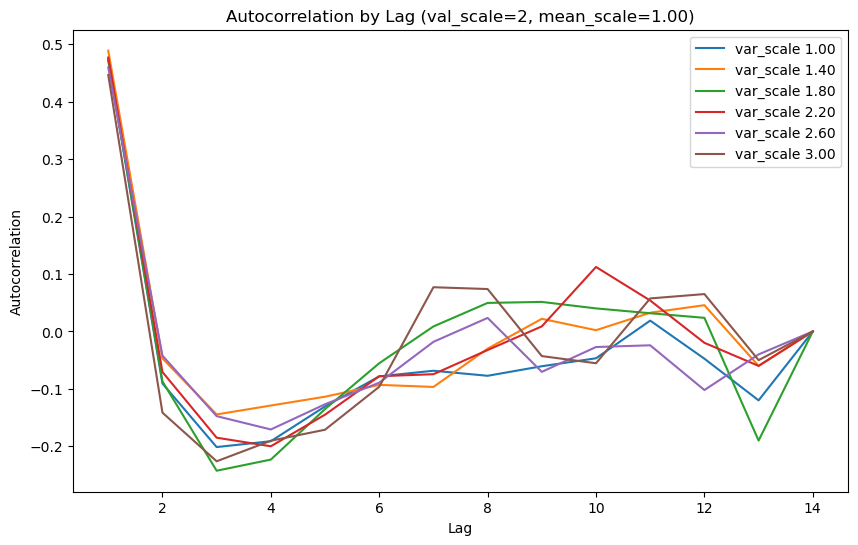

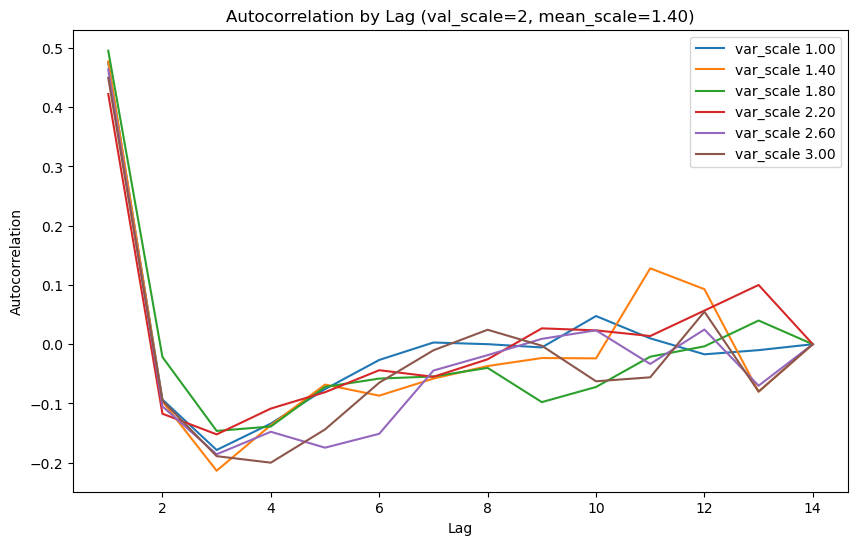

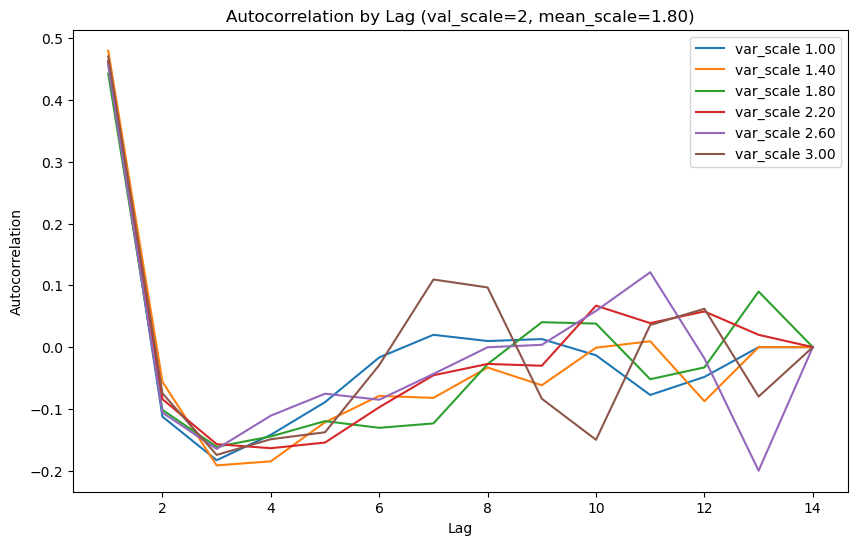

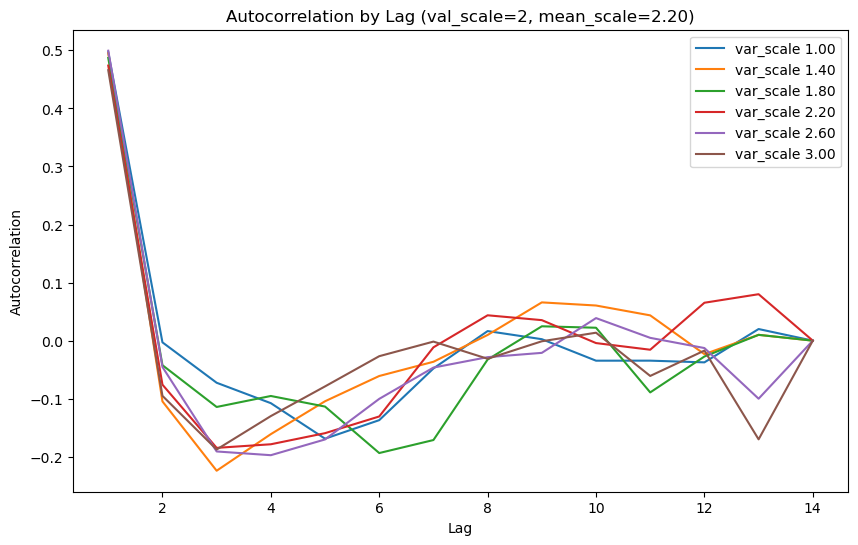

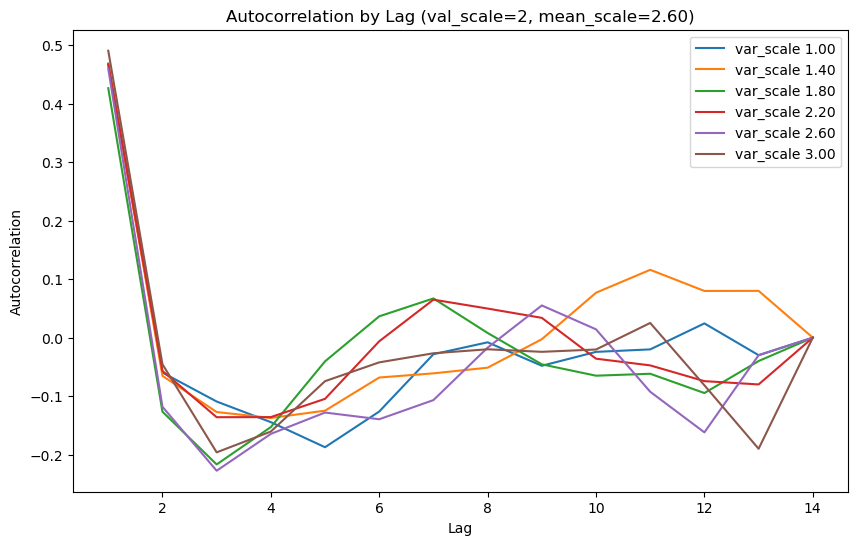

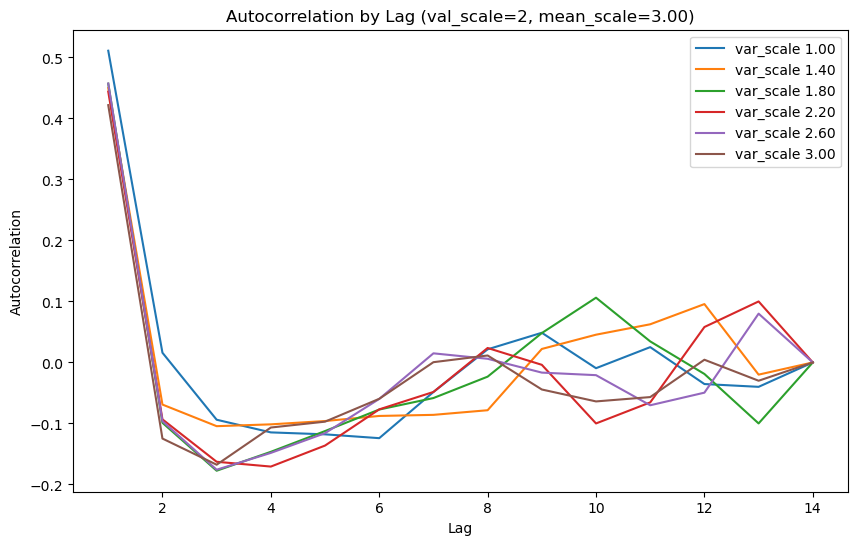

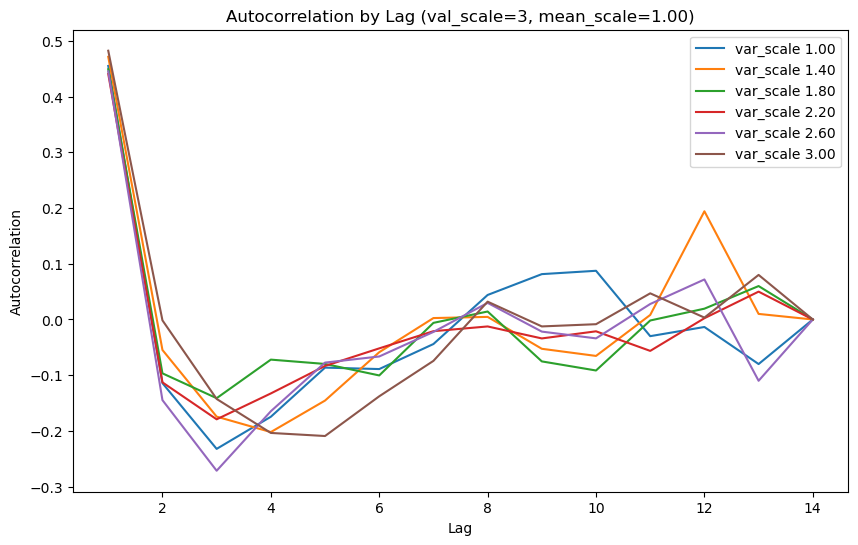

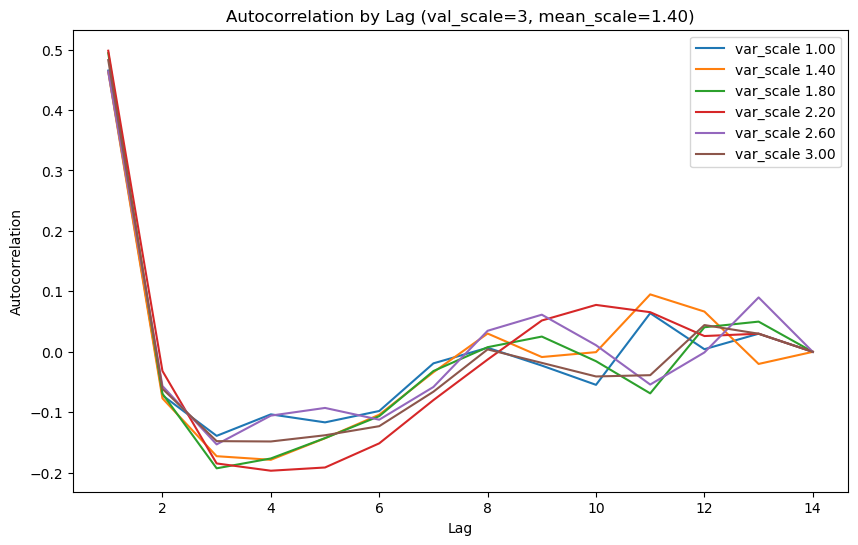

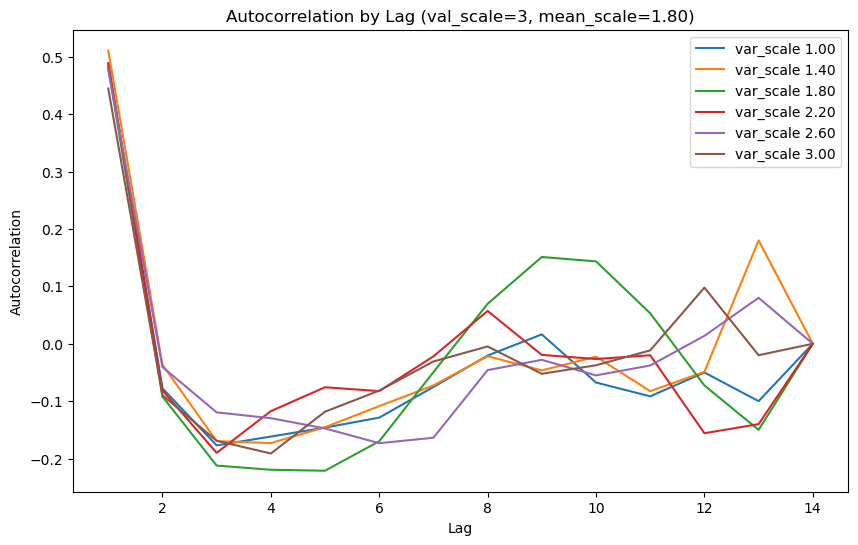

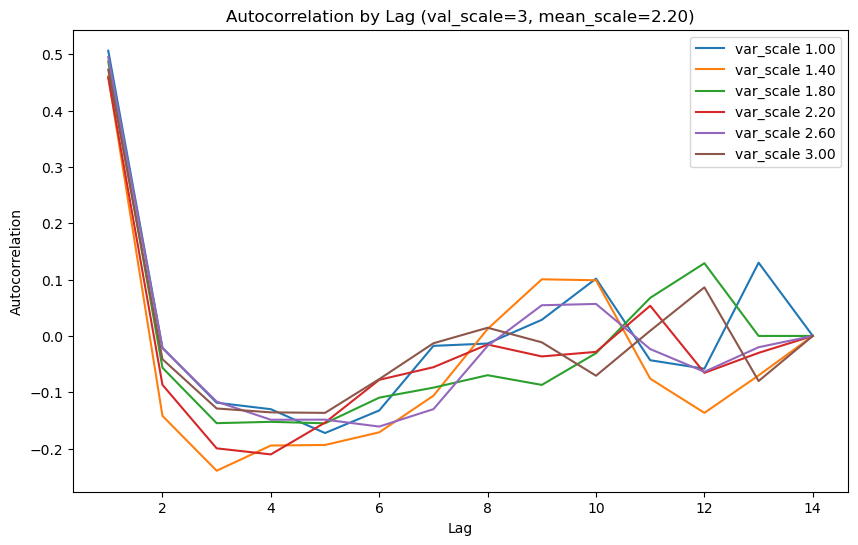

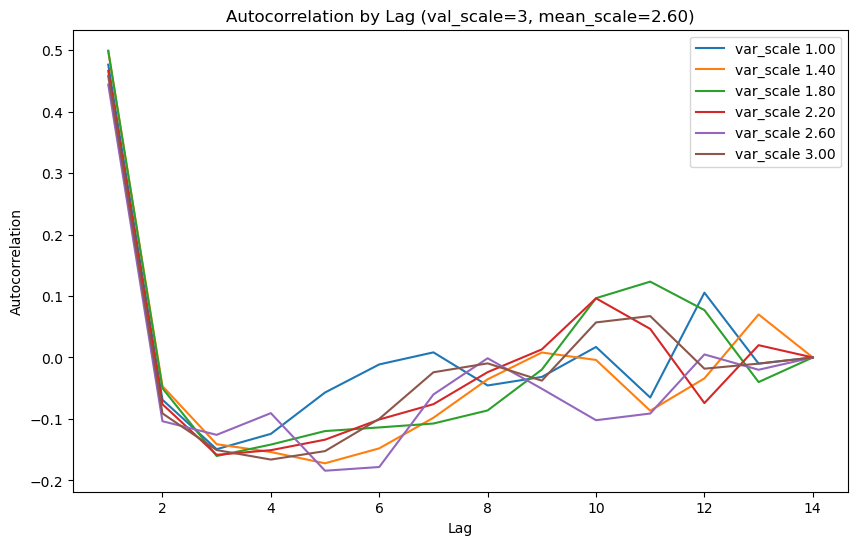

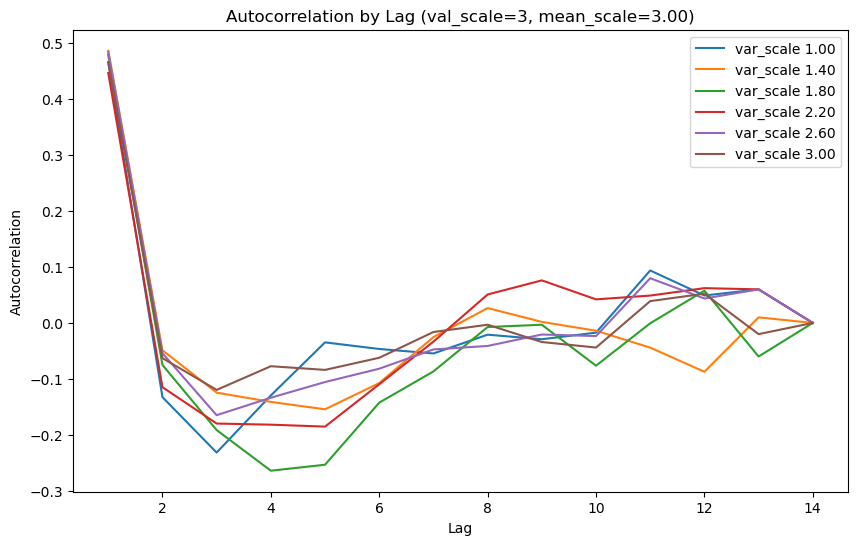

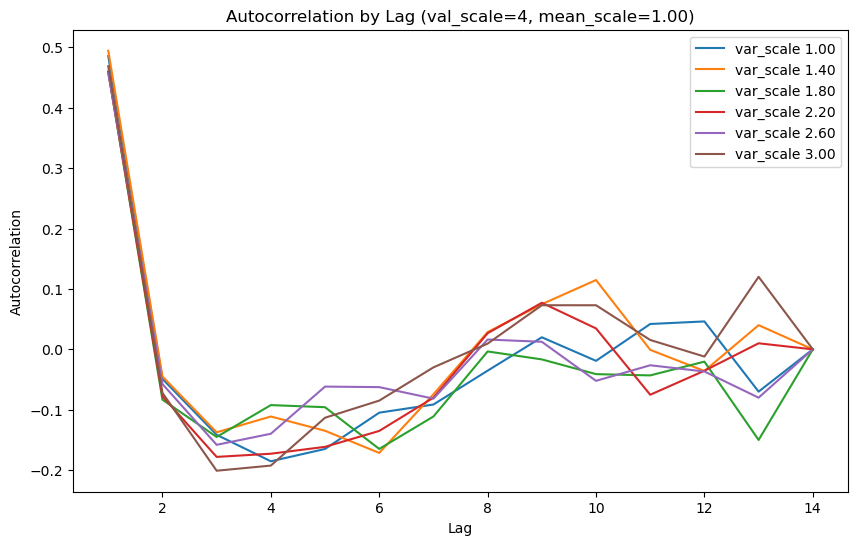

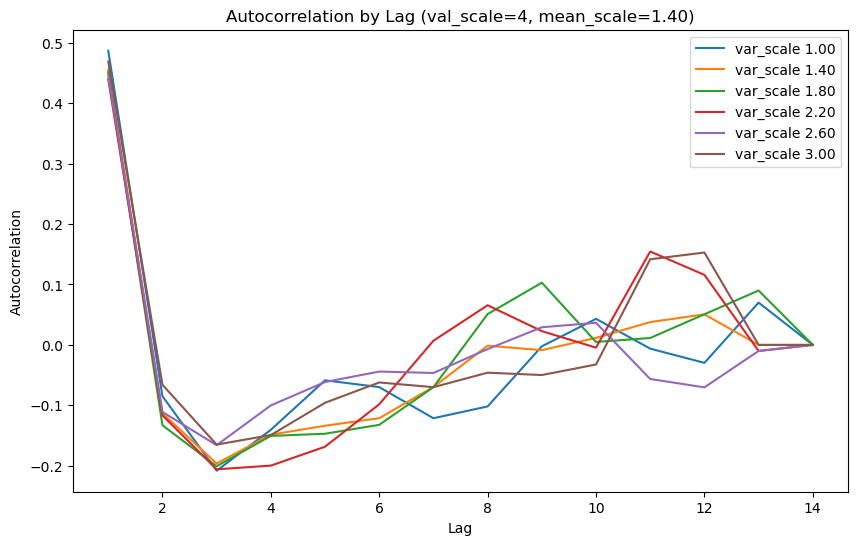

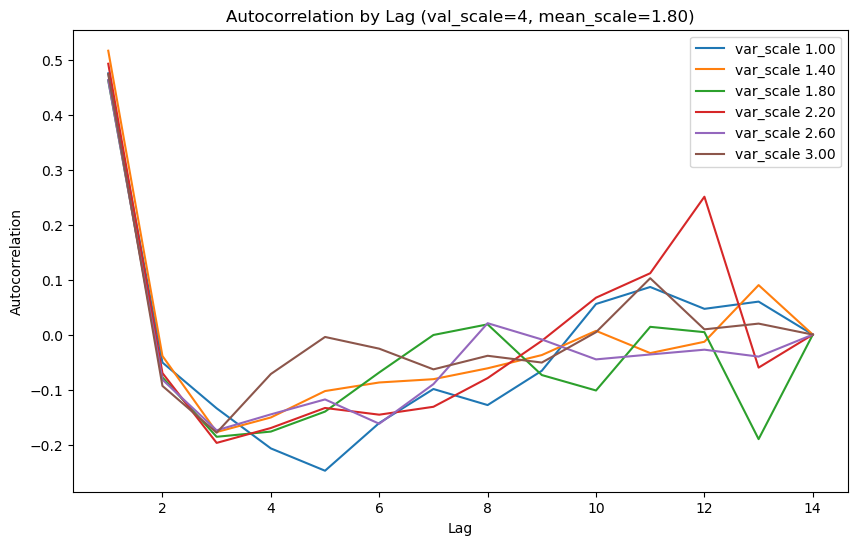

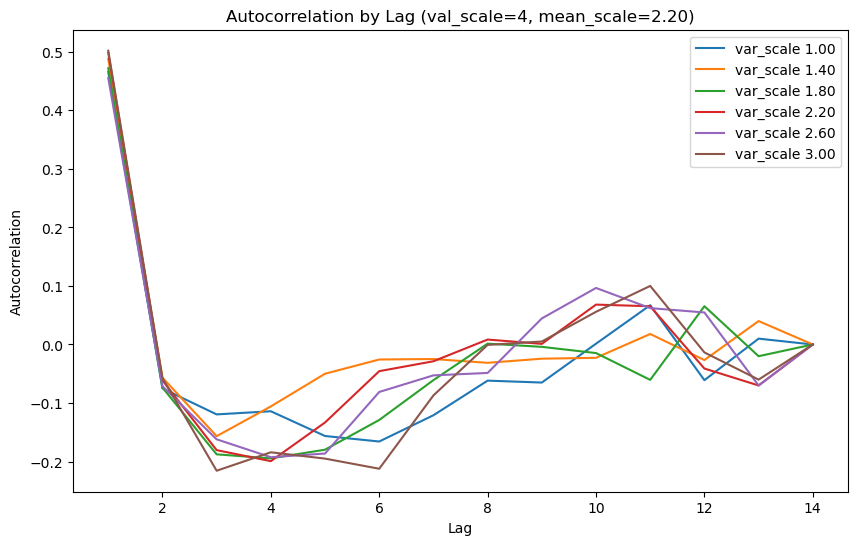

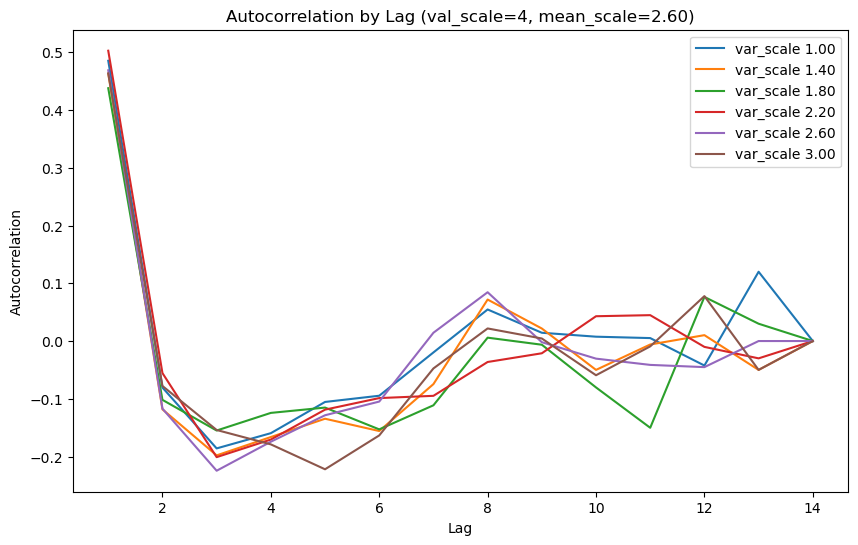

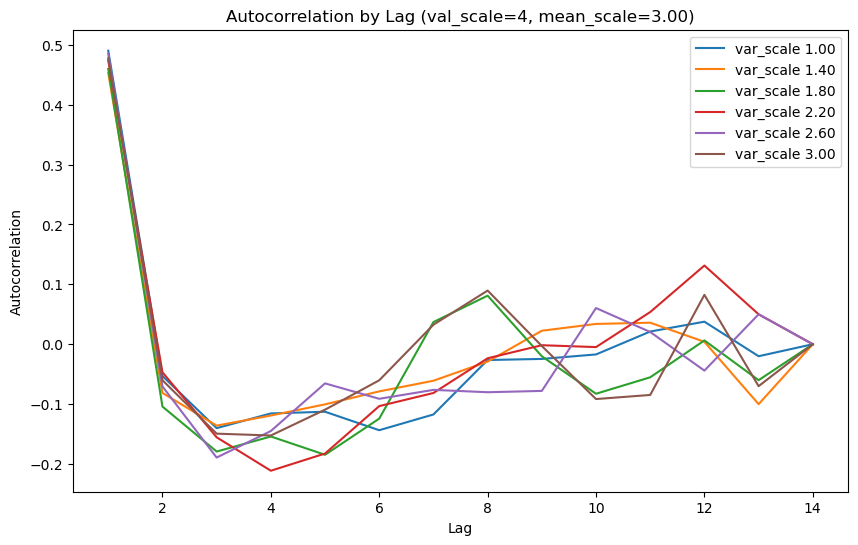

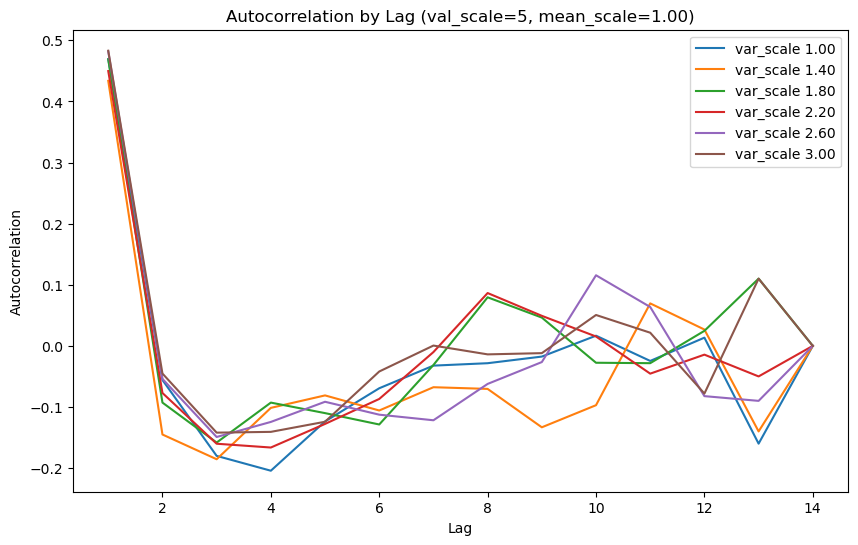

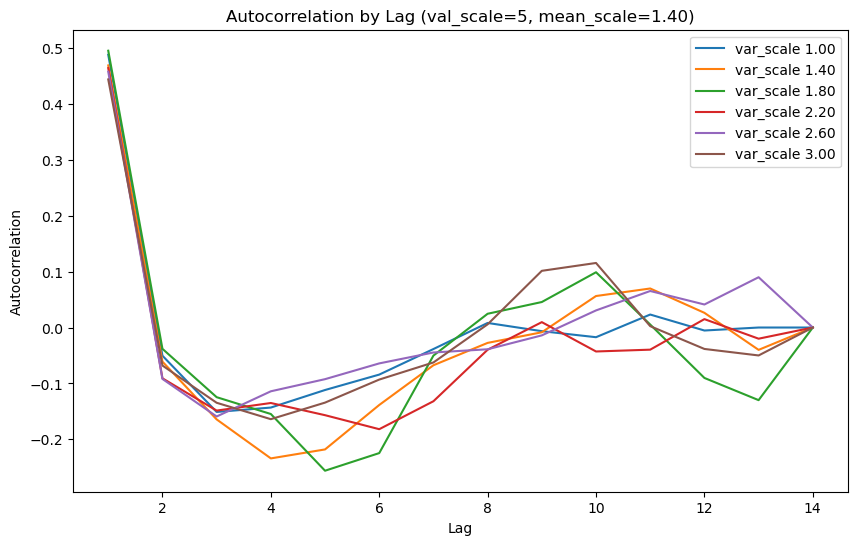

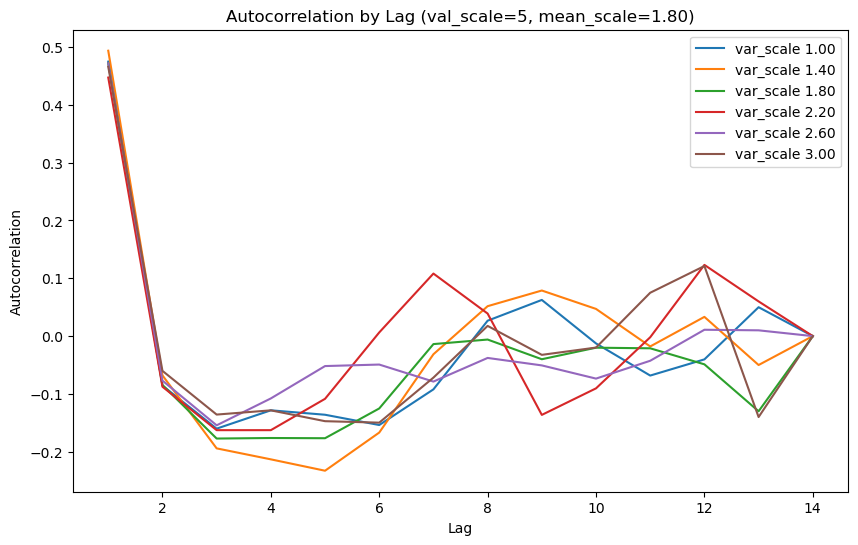

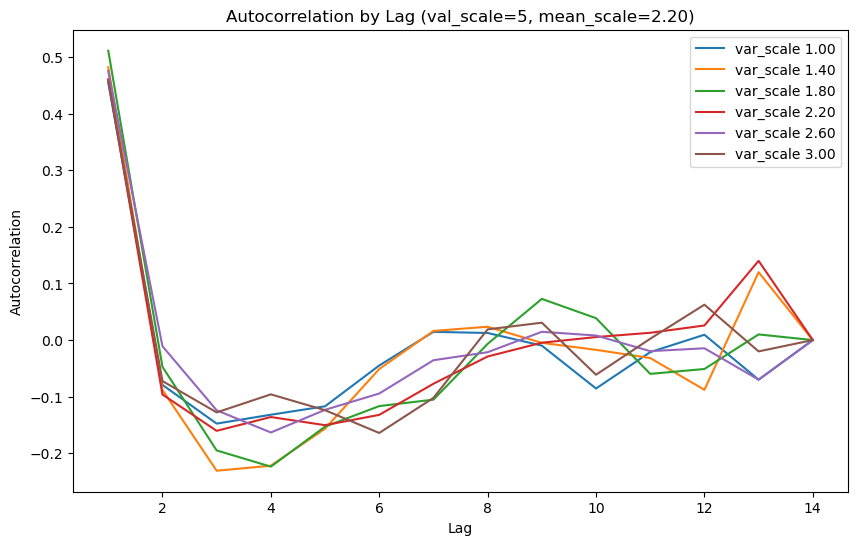

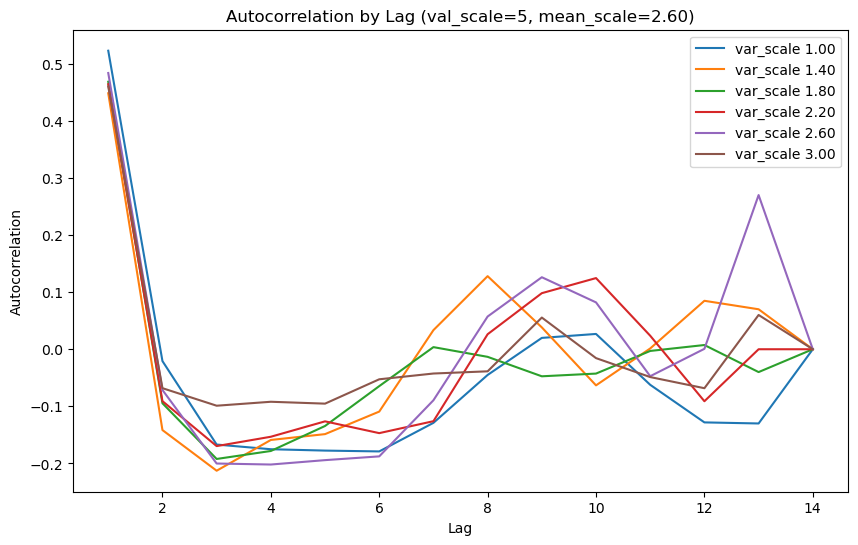

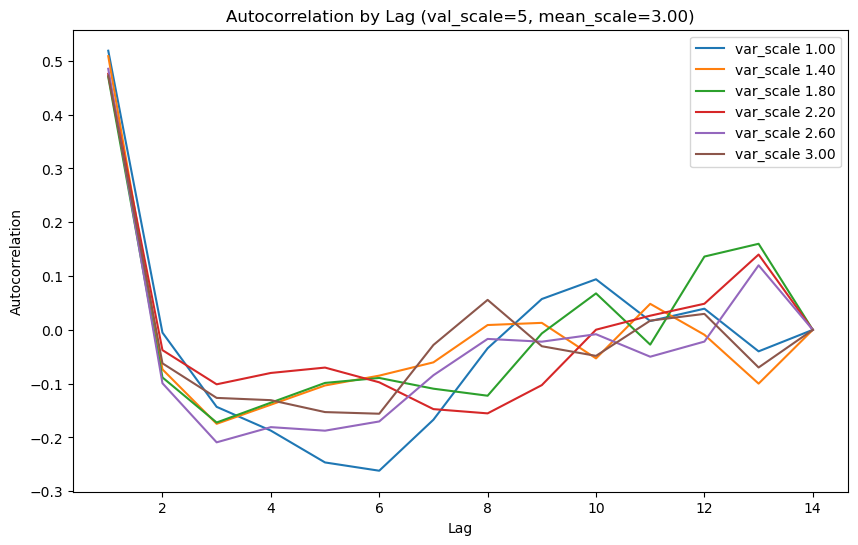

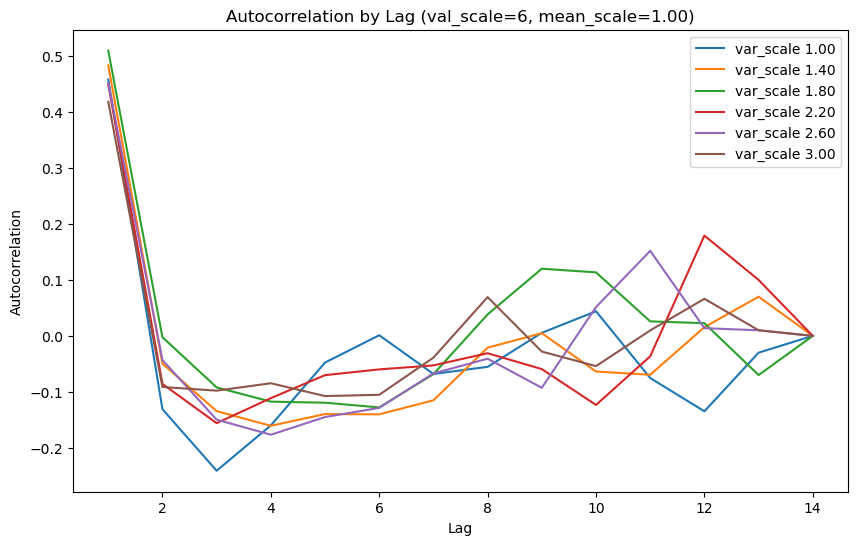

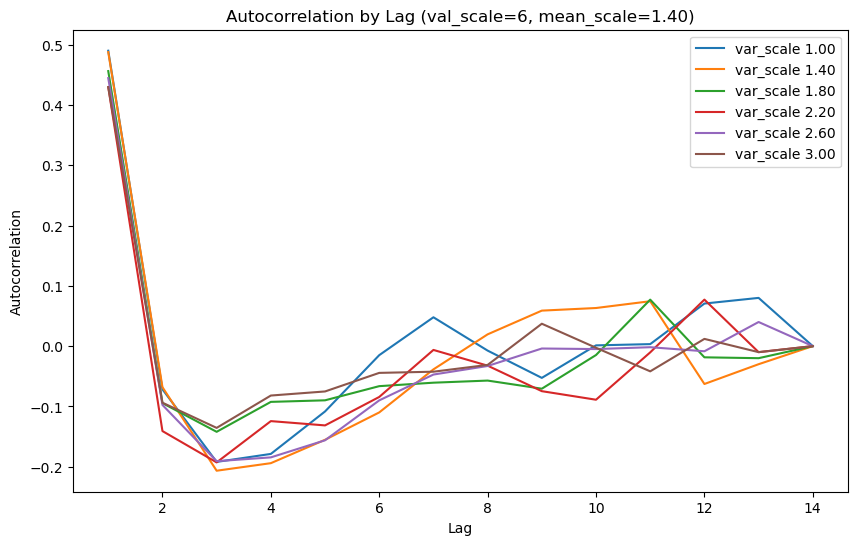

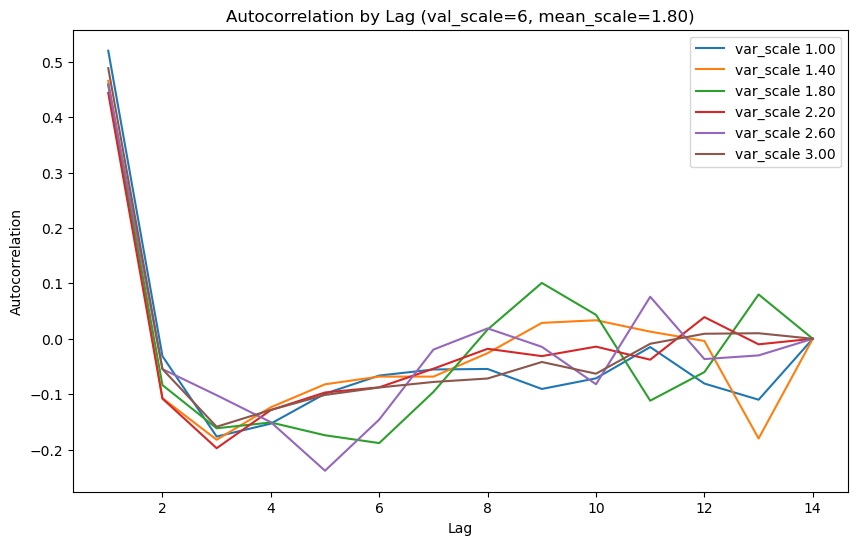

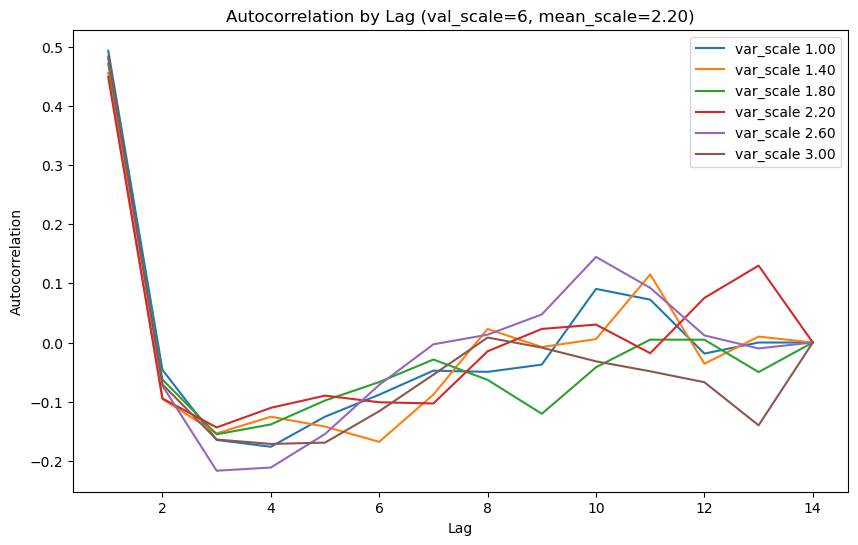

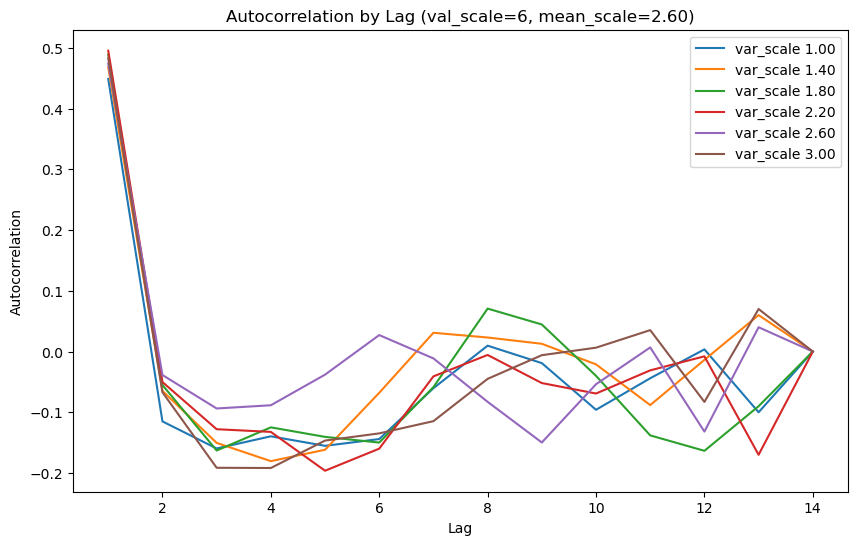

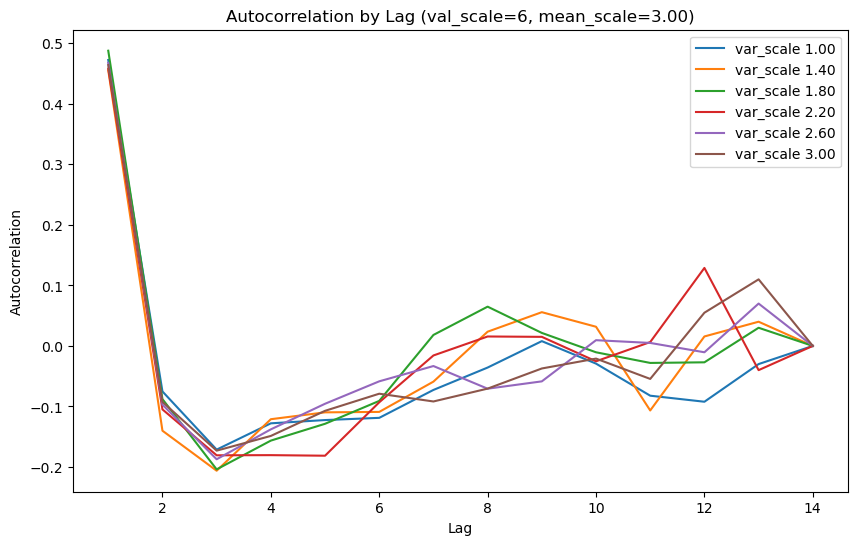

In [41]:
from tqdm import tqdm
# Simulation parameters
n_lists = 100
list_length = 15
lag_max = 14

# Independent variables
val_scales = np.arange(1, 7)            # scales for val_range
mean_var_scales = np.linspace(1, 3, 6)  # scales for mean_range
var_scales = np.linspace(1, 3, 6)       # scales for var_range

# Base GP parameter ranges
base_val_range = (0, 15)
base_mean_range = (4, 10)
base_var_range = (2, 6)

results = {}

for val_scale in tqdm(val_scales, desc="Processing val_scales"):
    ac_per_mean_var = {}
    
    for mean_scale in mean_var_scales:
        ac_per_var = []
        
        for var_scale in var_scales:
            # Scale val_range independently
            scaled_val_range = (base_val_range[0]*val_scale, base_val_range[1]*val_scale)

            # Scale mean_range and var_range
            scaled_mean_range = (base_mean_range[0]/mean_scale, base_mean_range[1]*mean_scale)
            scaled_var_range = (base_var_range[0]/var_scale, base_var_range[1]*var_scale)

            scaled_gp_params = {
                "val_range": scaled_val_range,
                "mean_range": scaled_mean_range,
                "var_range": scaled_var_range,
                "decay_factor": 1.0,
                "effect_strength": 1.0
            }

            # Generate lists
            temp_vals = []
            for _ in range(n_lists):
                lst = ItemList(length=list_length, condition="Temporal", gp_params=scaled_gp_params)
                temp_vals.append(lst.vals)
            
            avg_ac = mean_autocorr(temp_vals)
            ac_per_var.append(avg_ac)

        ac_per_mean_var[mean_scale] = np.array(ac_per_var)  # var_scales x lags

    results[val_scale] = ac_per_mean_var

# --- Plotting ---
for val_scale, mean_dict in results.items():
    for mean_scale, ac_matrix in mean_dict.items():
        plt.figure(figsize=(10, 6))
        for i, var_scale in enumerate(var_scales):
            plt.plot(range(lag_max+1), ac_matrix[i, :lag_max+1], label=f"var_scale {var_scale:.2f}")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.title(f"Autocorrelation by Lag (val_scale={val_scale}, mean_scale={mean_scale:.2f})")
        plt.legend()
        plt.show()


In [ ]:
subjects_dict = load_data('subjects_data.pkl')

In [ ]:
subjects_dict['LTP564']

In [ ]:
first_recall_probs = subjects_dict['LTP564']['first_recall_probs']
temporal_clustering = subjects_dict['LTP564']['temporal_clustering']
spatial_clustering = subjects_dict['LTP564']['spatial_clustering']
crp_probs = subjects_dict['LTP564']['crp_probs']

In [ ]:
LTP564 = SimulatedSubjectData(subject='LTP564', first_recall=first_recall_probs, lag_crp=crp_probs, recall_rate=0.705, value_acc= 0.6)

In [ ]:
pos = LTP564.generateLocations(r=1, n=len(LTP564.first_recall))
LTP564.generateLists(len(LTP564.first_recall), 3, wordpool=wordpool, pos=pos)

In [ ]:
def addCRPProbsCheck(crp_dict):
    """
    Returns the sum of probabilities in a CRP dictionary and checks if it exceeds 1.

    Args:
        crp_dict (dict): CRP dictionary {lag: prob}.

    Returns:
        float: Sum of probabilities.

    Raises:
        ValueError: If total probability exceeds 1.
    """
    total_prob = sum(crp_dict.values())
    if total_prob > 1.0 + 1e-8:  # allow tiny floating point error
        raise ValueError(f"Total probability exceeds 1: {total_prob}")
    return total_prob

In [ ]:
crp = LTP564.convertCRP(LTP564.lag_crp)
print(crp)

In [ ]:
addCRPProbsCheck(crp)

In [ ]:
addCRPProbsCheck(crp)

In [ ]:
item_list1 = LTP564.item_lists[0]
proc = ItemProcessor(item_list1)

In [ ]:
proc.hasItems()

In [ ]:
crp = LTP564.convertCRP(LTP564.lag_crp)
item, val, pos, serialpos = proc.pickFirstItem(first_recall_probs)

In [ ]:
first_recall_probs

In [ ]:
proc.pickItem(crp, serialpos)

In [ ]:
LTP564.generateData(list_len=15,num_lists=2, wordpool=wordpool, gen_pos=True, guess_by_subset=True, reset=True)